# Settings, Directory Specs, and Imports

In [1]:
# 0 = no streamlit
# 1 = test user inputs
# 2 = run in streamlit
streamlit_status = 0
#file_name_pickle_read = 'model_2020_06_06_1105.pickle'
do_plots = 1

dir_read = '/Users/rachellehorwitz/Documents/ViTalErt/data/filtered05/'
#dir_read = '/Users/rachellehorwitz/Documents/VTAlert/over18_eicu/'

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, confusion_matrix, plot_confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split, ShuffleSplit, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import streamlit as st
import pickle
from datetime import datetime
import pyprojroot


matplotlib.rcParams.update({'font.size': 22})

# Function Definitions

In [2]:
def now_to_str():
    now = str(datetime.now())
    return now[0:4] + '_' + now[5:7] + '_' + now[8:10] + '_' + now[11:13] + now[14:16]

# Defining X and y

In [3]:
Xy = pd.read_csv('/Users/rachellehorwitz/Documents/ViTalErt/notebooks/Xy_2020_06_10_1425.csv')
Xy = Xy.set_index('patientunitstayid')
y = Xy.pop('label')
X = Xy.copy()
X.columns.shape

(34,)

In [4]:
cols = list(X.columns)

In [5]:
vars_categ = ['gender_Female', 'ethnicity_AfricanAmerican', 'ethnicity_Asian', 'ethnicity_Caucasian', \
             'ethnicity_Hispanic', 'ethnicity_NativeAmerican', 'ethnicity_Other/Unknown',\
              'unitstaytype_admit', 'unitstaytype_readmit', 'unitstaytype_transfer', \
             'thrombolytics', 'aids', 'hepaticfailure' 'lymphoma', 'metastiticcancer', 'leukemia', \
             'immunosuppression', 'cirrhosis', 'activetx', 'ima', 'midur',
               'ventday1', 'oobventday1', 'oobintubday1', 'diabetes']

In [6]:
vars_cont = ['age', 'admissionweight', 'admissionheight', 'bmi', \
             'verbal', 'motor', 'eyes', 'visitnumber', 'heartrate']

In [7]:
def grid_search_wrapper(clf, X_train_sc, y_train, X_test_sc, y_test, scoring):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)    
    
    weights = np.array([0.001, \
                        y[y==1].shape[0] / (y[y==1].shape[0] + y.shape[0]), \
                        0.005, 0.01, 0.2, 0.5])
    
    hyperparam_grid = {'penalty': ['l1', 'l2'], \
                       'C': np.logspace(-6, 3, 10), \
                       'class_weight': [{0: x,   1: 1-x} for x in weights], \
                       'fit_intercept': [True, False]}
    #GridSearchCV(clf, param, scoring='f1_score',refit=True,cv=10)
    
    
    grid_search = GridSearchCV(clf, scoring=scoring, param_grid=hyperparam_grid, refit=True,
                           cv=skf, return_train_score=True, n_jobs=4)
    grid_search.fit(X_train_sc, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test_sc)

    print('Best params for ' + scoring)
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Logistic Regression optimized')
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search, y_pred

In [8]:

from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

clf = LogisticRegression()
# clf.fit(X_train_sc, y_train)

grid_search_clf_rocauc, y_pred_rocauc = grid_search_wrapper(clf, X_train_sc, y_train, X_test_sc, y_test, 'roc_auc')


# yhat_logisticRegr_sc = logisticRegr_sc.predict(X_test_sc)
# prob_logisticRegr_sc = logisticRegr_sc.predict_proba(X_test_sc)[:,1]


Best params for roc_auc
{'C': 0.01, 'class_weight': {0: 0.005, 1: 0.995}, 'fit_intercept': False, 'penalty': 'l2'}

Confusion matrix of Logistic Regression optimized
     pred_neg  pred_pos
neg     16522     12642
pos        14        76


In [23]:
clf_w_best_params = LogisticRegression(class_weight={0: 0.005, 1: 0.995}, C=0.01, fit_intercept=False, penalty='l2')
clf_w_best_params.fit(X_train_sc, y_train)
y_pred = clf_w_best_params.predict(X_test_sc)
y_probs = clf_w_best_params.predict_proba(X_test_sc)#[:,1]
# print('accuracy is ' + str(accuracy_score(y_test, y_pred)))
# print('precision is ' + str(precision_score(y_test, y_pred)))



# print('F1 score is ' + str(f1_score(y_test, y_pred_rocauc)))
# print('AUC is ' + str(roc_auc_score(y_test,y_probs)))
# print('Min prob is ' + str(y_probs.min()))
# print('Max prob is ' + str(y_probs.max()))

In [24]:
y_probs

array([[0.57443396, 0.42556604],
       [0.38251181, 0.61748819],
       [0.47566134, 0.52433866],
       ...,
       [0.55886687, 0.44113313],
       [0.62246497, 0.37753503],
       [0.60363094, 0.39636906]])

Logistic: ROC AUC=0.705


<IPython.core.display.Javascript object>


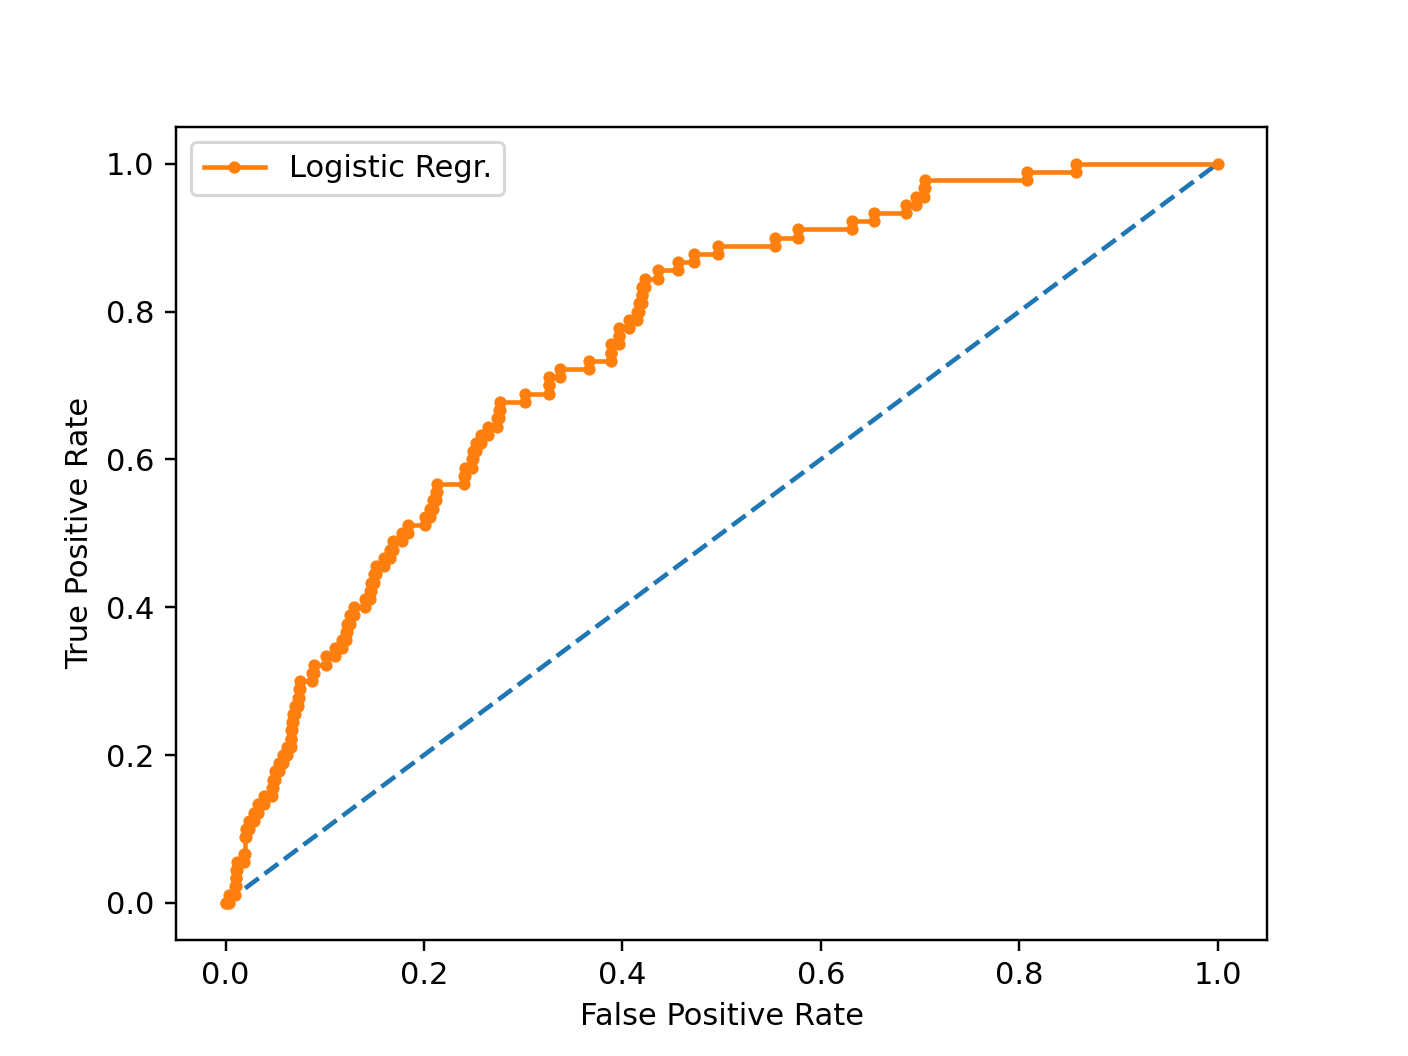

In [25]:
%matplotlib notebook
noskill_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, noskill_probs)
lr_fpr, lr_tpr, threshold_array = roc_curve(y_test, clf_w_best_params.predict_proba(X_test_sc)[:,1])

y_pred_new = lr_tpr>0

logisticRegr_auc = roc_auc_score(y_test, y_pred)
print('Logistic: ROC AUC=%.3f' % (logisticRegr_auc))

plt.figure()
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regr.')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# # show the legend
plt.legend()
# # show the plot
plt.show()

In [12]:
lr_tpr[lr_tpr>0.8]

array([0.81111111, 0.81111111, 0.82222222, 0.82222222, 0.83333333,
       0.83333333, 0.84444444, 0.84444444, 0.85555556, 0.85555556,
       0.86666667, 0.86666667, 0.87777778, 0.87777778, 0.88888889,
       0.88888889, 0.9       , 0.9       , 0.91111111, 0.91111111,
       0.92222222, 0.92222222, 0.94444444, 0.94444444, 0.95555556,
       0.95555556, 0.96666667, 0.96666667, 0.97777778, 0.97777778,
       0.98888889, 0.98888889, 1.        , 1.        ])

In [13]:
result = np.where(lr_tpr>0.8)

In [14]:
result

(array([147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
        173, 174, 175, 176, 177, 178, 179, 180]),)

In [15]:
threshold_array[147]

0.5070076411576808

In [16]:
print(y_pred)

[0 1 1 ... 0 0 0]


In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred, normalize='true')

array([[0.56652037, 0.43347963],
       [0.15555556, 0.84444444]])

In [18]:
grid_search_clf_rocauc

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprec...
             param_grid={'C': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03]),
                         'class_weight': [{0: 0.001, 1: 0.999},
                                          {0: 0.003080718925292566,
                                    

In [19]:
# clf_w_best_params = LogisticRegression(class_weight='balanced', C=0.0001, fit_intercept=True)
# clf_w_best_params.fit(X_train_sc, y_train)
# y_pred = clf_w_best_params.predict(X_test_sc)
# print('accuracy is ' + str(accuracy_score(y_test, y_pred)))
# print('precision is ' + str(precision_score(y_test, y_pred)))

In [20]:
# cm = confusion_matrix(list(y_test), y_pred)
# plot_confusion_matrix(clf_w_best_params, X_test_sc, list(y_test))
# plot_confusion_matrix(clf_w_best_params, X_test_sc, list(y_test),  normalize='true')

# # ROC curve (https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
# noskill_probs = [0 for _ in range(len(y_test))]
# noskill_auc = roc_auc_score(y_test, noskill_probs)
# logisticRegr_auc = roc_auc_score(y_test, y_pred)
# print('No Skill: ROC AUC=%.3f' % (noskill_auc))
# print('Logistic: ROC AUC=%.3f' % (logisticRegr_auc))
# ns_fpr, ns_tpr, _ = roc_curve(y_test, noskill_probs)
# lr_fpr, lr_tpr, _ = roc_curve(y_test, clf_w_best_params.predict_proba(X_test_sc)[:,1])

# plt.figure()
# # plot the roc curve for the model
# plt.plot(ns_fpr, ns_tpr, linestyle='--')
# plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regr.')
# # axis labels
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# # show the legend
# plt.legend()
# # show the plot
# plt.show()


In [21]:
#y_pred.shape

In [22]:
# # Get feature weights and put into dataframe
# mydict = {'feature': X_train.columns, 'coef': list(clf_w_best_params.coef_.reshape(-1,1).flatten())}
# features_weights = pd.DataFrame(mydict)
# features_weights = features_weights.assign(abs_weight=np.abs(features_weights['coef']))
# features_weights
